# CUSUM experiments for the retraining note (artifical data)

## CUSUM, pointwise plots

Let us try CUSUM.
The following code runs 23 secs (for $10^8$ product) or 406 secs (for $10^9$ product).

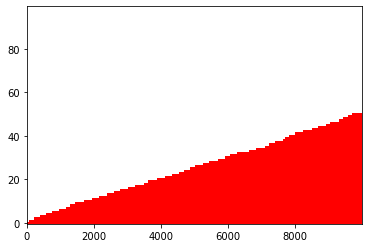

406.4698278903961


In [43]:
import numpy as np

# The key parameters: the 3 below plus Ncal (line 15)
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; in the book: 0.001; canonical: 0.01
K = 10**3     # the number of runs of the experiment
N = 10**4      # the number of observations
C = 10**2      # the upper bound on the threshold

import matplotlib.pyplot as plt
import time
start = time.time()

statistics = np.zeros((C,N))    # the final statistics

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

MartCap = np.empty(Ncal)  # the total capital of martingales in each state
for k in range(K):
  MartCap[:] = 1/Ncal       # the uniform initial distribution
  Capital = np.sum(MartCap) # the total capital (1)
  min_Cap = Capital         # minimal capital so far (1)
  CUSUM = 1      # initial CUSUM statistic
  max_CUSUM = 1  # maximal CUSUM so far
  # generating the dataset:
  p = rg.random(N)
  for n in range(N):  # going through the observations
    # Jumps mixing starts
    MartCap[:] = (1-Jrate)*MartCap[:] + (Jrate/Ncal)*Capital
    # Jumps mixing ends
    for kk in range(Ncal):
      MartCap[kk] = MartCap[kk] * my_cal(p[n],kk)
    Capital = np.sum(MartCap)
    if Capital < min_Cap:
      min_Cap = Capital
    CUSUM = Capital / min_Cap
    if CUSUM > max_CUSUM:
      max_CUSUM = CUSUM
    # updating the statistics:
    for i in range(min(C,int(np.floor(max_CUSUM)))):
      statistics[i,n] += 1
# normalizing:
statistics = statistics/K

# drawing heatmap:
# plt.imshow(statistics, cmap='hot')
cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(statistics, interpolation='nearest',origin='lower',
  cmap=cmap, norm=norm, aspect='auto')
plt.savefig("K=10^"+str(int(np.log10(K)))+"_heatmap.pdf", bbox_inches='tight')
plt.show()

end = time.time()
print(end - start)
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

Let me practice drawing:

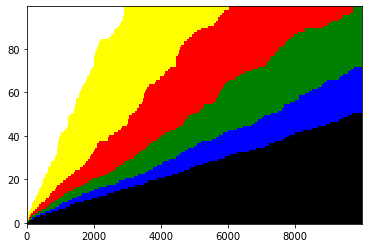

In [50]:
# drawing heatmap:
# plt.imshow(statistics, cmap='hot')
from matplotlib import colors
# plt.axes([0, 0, 1, 10000])
cmap = colors.ListedColormap(['white', 'yellow', 'red','green','blue','black'])
bounds = [0,0.1,0.2,0.3,0.4,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(statistics, interpolation='nearest', origin='lower', cmap=cmap, norm=norm, aspect='auto')
# plt.xscale("log")
# plt.yscale("log")
plt.savefig("K=10^"+str(int(np.log10(K)))+"_heatmap.pdf", bbox_inches='tight')
plt.show()

Next the version requiring lots of memory:

NameError: name 'legend' is not defined

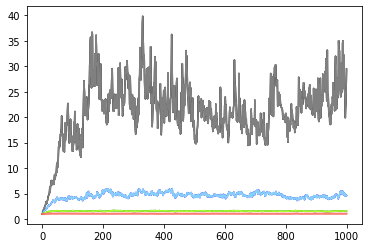

In [1]:
# This file is modelled on pointwise.py but requires a lot of memory.
import numpy as np

# The key parameters: the 3 below plus Ncal (line 16)
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01   # the jumping rate; default: 0.01
K = 10**3      # the number of runs of the experiment
N = 10**3      # the number of observations
reset_interval = 10000  # occasional reset to avoid capital undeflow

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

import time
start = time.time()

CUSUM = np.empty((K,N))             # the CUSUM statistics
max_CUSUM = np.empty((K,N))  # the max CUSUM statistics (record values so far)

MartCap = np.empty(Ncal)  # the total capital of martingales in each state
for k in range(K):
  MartCap[:] = 1/Ncal       # the uniform initial distribution
  Capital = np.sum(MartCap) # the total capital (1)
  min_Cap = Capital         # minimal capital so far (1)
  # generating the dataset:
  p = rg.random(N)
  for n in range(N):  # going through the observations
    # Jumps mixing starts
    MartCap[:] = (1-Jrate)*MartCap[:] + (Jrate/Ncal)*Capital
    # Jumps mixing ends
    for kk in range(Ncal):
      MartCap[kk] = MartCap[kk] * my_cal(p[n],kk)
    Capital = np.sum(MartCap)
    if Capital < min_Cap:
      min_Cap = Capital
    CUSUM[k,n] = Capital / min_Cap
    if n==0:
      max_CUSUM[k,n] = 1.0
    elsif CUSUM[k,n] > max_CUSUM[k,n-1]:
      max_CUSUM[k,n] = CUSUM[k,n]
    else:
      max_CUSUM[k,n] = max_CUSUM[k,n-1]
    # to avoid underflow:
    if n%reset_interval == 0:
      MartCap[:] = MartCap[:] / min_Cap
      Capital = Capital / min_Cap
      min_Cap = 1

# computing the percentile curves:
curve99 = np.empty(N)  # 99 percentile curve for CUSUM
curve95 = np.empty(N)  # 95 percentile curve for CUSUM
curve80 = np.empty(N)  # 80 percentile curve for CUSUM
curve50 = np.empty(N)  # 50 percentile curve for CUSUM
max_curve99 = np.empty(N)  # 99 percentile curve for max-CUSUM
max_curve95 = np.empty(N)  # 95 percentile curve for max-CUSUM
max_curve80 = np.empty(N)  # 80 percentile curve for max-CUSUM
max_curve50 = np.empty(N)  # 50 percentile curve for max-CUSUM
for n in range(N):  # going through the observations
  curve99[n] = np.percentile(CUSUM[:,n],99)
  curve95[n] = np.percentile(CUSUM[:,n],95)
  curve80[n] = np.percentile(CUSUM[:,n],80)
  curve50[n] = np.percentile(CUSUM[:,n],50)
  max_curve99[n] = np.percentile(max_CUSUM[:,n],99)
  max_curve95[n] = np.percentile(max_CUSUM[:,n],95)
  max_curve80[n] = np.percentile(max_CUSUM[:,n],80)
  max_curve50[n] = np.percentile(max_CUSUM[:,n],50)

# drawing the curves:
import matplotlib.pyplot as plt
# my_colors = ['k','b','g','r','grey','lightskyblue','greenyellow','salmon']
plt.plot(curve99,'k-',label='99%')
plt.plot(max_curve99,c='grey',label='max, 99%')
plt.plot(curve95,'b-',label='95%')
plt.plot(max_curve95,c='lightskyblue',label='max, 95%')
plt.plot(curve80,'g-',label='80%')
plt.plot(max_curve80,c='greenyellow',label='max, 80%')
plt.plot(curve50,'r-',label='50%')
plt.plot(max_curve50,c='salmon',label='max, 50%')
plt.legend(loc="best")
# plt.xscale("log")
# plt.yscale("log")
plt.savefig("CUSUM_K=10^"+str(int(np.log10(K)))+"_N=10^"+str(int(np.log10(N)))+"_pointwise.pdf", bbox_inches='tight')
plt.close()

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)
np.savetxt("K=10^"+str(int(np.log10(K)))+"_time_elapsed.txt",[end-start])

In [4]:
CUSUM[0,:]

array([1.        , 1.        , 1.02927543, 1.2047323 , 1.        ,
       1.        , 1.        , 1.        , 1.00070912, 1.01835224,
       1.10831357, 1.        , 1.05191357, 1.        , 1.01553013,
       1.        , 1.00624935, 1.01353539, 1.        , 1.        ,
       1.        , 1.05203245, 1.00227376, 1.        , 1.        ,
       1.01208676, 1.        , 1.02869536, 1.0718328 , 1.11740596,
       1.18631605, 1.13595027, 1.        , 1.04406295, 1.05115203,
       1.        , 1.        , 1.0767185 , 1.22566013, 1.14902868,
       1.18100137, 1.09536273, 1.13069565, 1.06314019, 1.02761471,
       1.13484911, 1.01523698, 1.05073212, 1.        , 1.05248124,
       1.13092609, 1.02999208, 1.12654886, 1.        , 1.        ,
       1.        , 1.        , 1.00416824, 1.        , 1.        ,
       1.01021382, 1.05011247, 1.13957398, 1.1112203 , 1.17467998,
       1.10712521, 1.1998452 , 1.01122773, 1.0385053 , 1.13423441,
       1.08563651, 1.        , 1.00891719, 1.        , 1.00000

In [5]:
max_CUSUM[0,:]

array([1.        , 1.        , 1.02927543, 1.2047323 , 1.        ,
       1.        , 1.        , 1.        , 1.00070912, 1.01835224,
       1.10831357, 1.        , 1.05191357, 1.        , 1.01553013,
       1.        , 1.00624935, 1.01353539, 1.        , 1.        ,
       1.        , 1.05203245, 1.00227376, 1.        , 1.        ,
       1.01208676, 1.        , 1.02869536, 1.0718328 , 1.11740596,
       1.18631605, 1.13595027, 1.        , 1.04406295, 1.05115203,
       1.        , 1.        , 1.0767185 , 1.22566013, 1.14902868,
       1.18100137, 1.09536273, 1.13069565, 1.06314019, 1.02761471,
       1.13484911, 1.01523698, 1.05073212, 1.        , 1.05248124,
       1.13092609, 1.02999208, 1.12654886, 1.        , 1.        ,
       1.        , 1.        , 1.00416824, 1.        , 1.        ,
       1.01021382, 1.05011247, 1.13957398, 1.1112203 , 1.17467998,
       1.10712521, 1.1998452 , 1.01122773, 1.0385053 , 1.13423441,
       1.08563651, 1.        , 1.00891719, 1.        , 1.00000

## Shiryaev-Roberts, pointwise plots

Let us now try SR.
The following code runs 45 secs (for $10^8$ product).

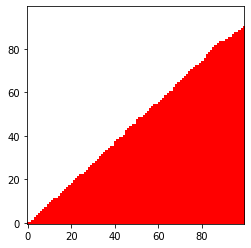

5.75539231300354


In [30]:
import numpy as np

# The key parameters: the 3 below plus Ncal (line 15)
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; in the book: 0.001; canonical: 0.01
K = 10**3     # the number of runs of the experiment
N = 10**2      # the number of observations
C = 10**2      # the upper bound on the threshold

import matplotlib.pyplot as plt
import time
start = time.time()

statistics = np.zeros((C,N))    # the final statistics

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

MartCap = np.empty(Ncal)  # the total capital of martingales in each state
for k in range(K):
  MartCap[:] = 1/Ncal       # the uniform initial distribution
  Capital = np.sum(MartCap) # the total capital (1)
  min_Cap = Capital         # minimal capital so far (1)
  SR = 0      # initial SR statistic
  max_SR = 0  # maximal SR so far
  # generating the dataset:
  p = rg.random(N)
  for n in range(N):  # going through the observations
    # Jumps mixing starts
    MartCap[:] = (1-Jrate)*MartCap[:] + (Jrate/Ncal)*Capital
    # Jumps mixing ends
    for kk in range(Ncal):
      MartCap[kk] = MartCap[kk] * my_cal(p[n],kk)
    Capital_new = np.sum(MartCap)
    SR = (1+SR) * Capital_new / Capital
    if SR > max_SR:
      max_SR = SR
    Capital = Capital_new
    # updating the statistics:
    for i in range(min(C,int(np.floor(max_SR)))):
      statistics[i,n] += 1
# normalizing:
statistics = statistics/K

# drawing heatmap:
# plt.imshow(statistics, cmap='hot')
cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(statistics, interpolation='nearest',origin='lower',
  cmap=cmap, norm=norm)
plt.savefig("K=10^"+str(int(np.log10(K)))+"_heatmap.pdf", bbox_inches='tight')
plt.show()

end = time.time()
print(end - start)
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

## Final values of the max CUSUM

(array([961.,  16.,   7.,   8.,   4.,   0.,   0.,   0.,   0.,   4.]),
 array([7.48128010e+00, 1.05956356e+03, 2.11164584e+03, 3.16372811e+03,
        4.21581039e+03, 5.26789267e+03, 6.31997494e+03, 7.37205722e+03,
        8.42413950e+03, 9.47622178e+03, 1.05283041e+04]),
 <a list of 10 Patch objects>)

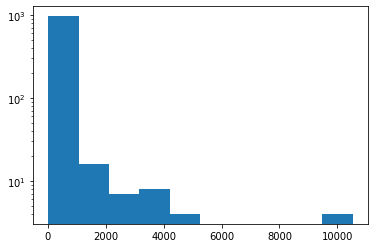

In [11]:
import numpy as np
import matplotlib.pyplot as plt
final = np.loadtxt("K=10^3_N=10^4_end.txt")
# plt.boxplot(final)
np.percentile(final,99)
plt.hist(final,log=True)

## Joint stuff

The following cell takes about 30 secs for $KN = 10^6$.

overshoots.shape (predicted 1000 x 21 ): (1000, 21)
Time elapsed: 40.8949875831604


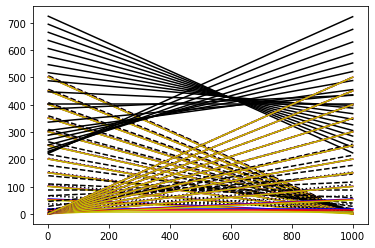

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# The key parameters:
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; default: 0.01
K = 10**3     # the number of runs of the experiment
N = 10**3      # the number of observations
# the slope of the straight line I am checking (An + overshoot):
A = np.linspace(-0.5,0.5,21)  # possible slopes
# A = np.array([0])
reset_interval = 10000     # occasional reset to avoid undeflow

import time
start = time.time()

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

overshoots = -np.inf*np.ones((K,A.size))  # the overshoots initialized
last_overshoot = np.zeros((K,A.size))     # the last overshoots initialized
for k in range(K):
  # generating the dataset:
  p = rg.random(N)
  MartCap = np.empty(Ncal)  # the total capital of martingales in each state
  MartCap[:] = 1/Ncal       # the uniform initial distribution
  Capital = np.sum(MartCap) # the total capital (1)
  min_Cap = Capital         # minimal capital so far (1)
  # print(Capital)
  CUSUM = 1      # initial CUSUM statistic
  for n in range(N):  # going through the observations
    # Jump mixing starts
    MartCap[:] = (1-Jrate)*MartCap[:] + (Jrate/Ncal)*Capital
    # Jump mixing ends
    for kk in range(Ncal):
      MartCap[kk] = MartCap[kk] * my_cal(p[n],kk)
    Capital = np.sum(MartCap)
    if Capital < min_Cap:
      min_Cap = Capital
    CUSUM = Capital / min_Cap
    for i in range(A.size):
      new_overshoot = CUSUM - A[i]*(n+1)
      if new_overshoot > overshoots[k,i]:
        overshoots[k,i] = new_overshoot
        last_overshoot[k,i] = n
    # print("k, n, Capital, min_Cap, CUSUM =",k,n,Capital,min_Cap,CUSUM)
    # print("last overshoot =",overshoots[k])
    ## to avoid underflow:
    # if n%reset_interval == 0:
    #   MartCap[:] = MartCap[:] / min_Cap
    #   Capital = Capital / min_Cap
    #  min_Cap = 1

print("overshoots.shape (predicted", K, "x", A.size, "):", overshoots.shape)

conf_levels = np.array([0.99, 0.95, 0.90, 0.80, 0.75, 0.5])
# conf_levels = np.array([0.99, 0.95, 0.90])
# conf_levels = np.array([0.95])

quantiles = np.empty((A.size,conf_levels.size))
average_height = np.empty((A.size,conf_levels.size))

my_colors = ['k','k','k','b','r','y']
my_styles = ['-','--',':','-','-','-']

for i in range(A.size):
  for j in range(conf_levels.size):
    quantiles[i,j] = np.quantile(overshoots[:,i],conf_levels[j])
    average_height[i,j] = A[i]*(N+1)/2 + quantiles[i,j]
    plt.plot([1,N],[quantiles[i,j],A[i]*N+quantiles[i,j]],c=my_colors[j],ls=my_styles[j])

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

In [7]:
last_CUSUM.size

1000

In [34]:
quantiles[0,:]

array([3.54471376, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       ])

In [37]:
overshoots[:,0]

array([  0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,  30.95749426,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5972762 ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
        18.10891218,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5       ,
         0.5       ,   0.5       ,   0.5       ,   0.5 

## Sandpit

In [3]:
import numpy as np
A = np.linspace(0,0.5,11)
print(A)
print(A.size)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
11


In [7]:
B = np.linspace(0,0.5,11)
C = A+B
print(C)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [4]:
A = -np.inf*np.ones(3)

In [5]:
A+1

array([-inf, -inf, -inf])

In [4]:
conf_levels = np.array([0.99, 0.95, 0.90, 0.80, 0.75, 0.5])
conf_levels.size

6